In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
from tensorflow.keras import regularizers # Figure out how to import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [2]:

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt

data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2021-08-03 09:11:12--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-08-03 09:11:13 (76.3 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [3]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(64,return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 128)           84480     
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense (Dense)                (None, 1605)              52965     
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 5,636,019
Trainable params: 5,636,019
Non-trainable params: 0
______________________________________________

In [4]:
%%time
history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 22s 24ms/step - loss: 6.8715 - accuracy: 0.0222
Epoch 2/100
484/484 [==============================] - 12s 24ms/step - loss: 6.5000 - accuracy: 0.0207
Epoch 3/100
484/484 [==============================] - 12s 24ms/step - loss: 6.4002 - accuracy: 0.0252
Epoch 4/100
484/484 [==============================] - 12s 24ms/step - loss: 6.2794 - accuracy: 0.0268
Epoch 5/100
484/484 [==============================] - 12s 24ms/step - loss: 6.1957 - accuracy: 0.0341
Epoch 6/100
484/484 [==============================] - 12s 24ms/step - loss: 6.1208 - accuracy: 0.0376
Epoch 7/100
484/484 [==============================] - 11s 23ms/step - loss: 6.0489 - accuracy: 0.0396
Epoch 8/100
484/484 [==============================] - 11s 23ms/step - loss: 5.9830 - accuracy: 0.0435
Epoch 9/100
484/484 [==============================] - 11s 23ms/step - loss: 5.9102 - accuracy: 0.0458
Epoch 10/100
484/484 [==============================] - 11s 23ms/step - l

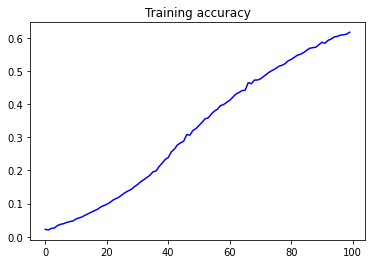

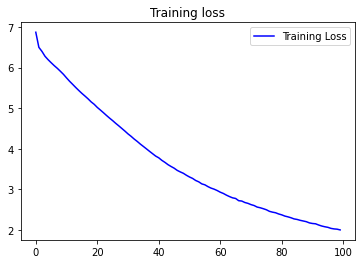

In [5]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [6]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Help me Obi Wan Kenobi, you're my only hope of effect alone sits grew it up new increase assured mine eye well is mine eye new eye were were beauty's hair 'will' and boundless lack and all myself which expense or weary wondrous son grow days had dyed dyed date pride part to this spacious canst leave thee bear afloat expire expire aspect crime aspect grew to pleasure razed done you doth prove me another near delight part days meet new turn'd treasure blood doth woman's son boast that that will not mine eye where it is appetite room sits grew to wrinkles possession ' knowing me well shows
